In [1]:
import json
import requests
import datetime as dt
import numpy as np
import pandas as pd
from binance.client import Client
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import sklearn
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import \
    TimeSeriesSplit  # you have everything done for you
# for time-series cross-validation set 5 folds
tscv = TimeSeriesSplit(n_splits=5)

# Getting data for last year with 30 min interval

In [2]:
api_key='hKmlFuyZiyNlaN6ARvCKnhF5owS6yrVJolMeSBfThE5Hc6L26aRM2Z3N8EuVQf0y'
secret_key='B4c5Cr9vwsubR19XK05axHk6aSGhnP91GdXLY57LlaYoUNMf4s5egKIHhtgfJYAd'

client = Client(api_key, secret_key)

df= pd.DataFrame(client.get_historical_klines('BTCUSDT','30m',
                                              str((dt.datetime.now() - dt.timedelta(weeks=17))),
                                              str((dt.datetime.now()))))

df.columns=['open_time','open','high','low','close','volume',
           'close_time','q_vol','trades','taker_buy_volume',
            'taker_q_volume','ignored']

df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
df['open_time'] = df.open_time + dt.timedelta(hours=3)
df = df.set_index('open_time')

df['const'] = np.ones(len(df))

df['trend'] = np.arange(len(df))
df['time'] = df.index 
df=df.drop('close_time',axis=1)
df=df.astype(np.float32,errors='ignore')
df

,open,high,low,close,volume,q_vol,trades,taker_buy_volume,taker_q_volume,ignored,const,trend,time
open_time,,,,,,,,,,,,,
2023-03-26 16:30:00,27896.330078,28194.400391,27896.330078,28149.990234,3789.125244,106368032.0,65189.0,2086.291992,5.855552e+07,0.0,1.0,0.0,2023-03-26 16:30:00
2023-03-26 17:00:00,28150.000000,28150.000000,27937.029297,27943.640625,2328.209229,65301244.0,40537.0,1015.905334,2.849568e+07,0.0,1.0,1.0,2023-03-26 17:00:00
2023-03-26 17:30:00,27943.630859,27964.900391,27695.000000,27795.220703,4417.102051,122759616.0,69650.0,2083.070557,5.788842e+07,0.0,1.0,2.0,2023-03-26 17:30:00
2023-03-26 18:00:00,27795.220703,27878.890625,27750.000000,27831.509766,1516.374512,42183356.0,29908.0,771.297668,2.145731e+07,0.0,1.0,3.0,2023-03-26 18:00:00
2023-03-26 18:30:00,27831.519531,27867.779297,27717.259766,27803.890625,1153.217773,32048470.0,29274.0,591.164124,1.642873e+07,0.0,1.0,4.0,2023-03-26 18:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-23 11:00:00,29916.000000,29923.839844,29887.599609,29897.400391,204.692474,6121384.0,6539.0,105.814682,3.164349e+06,0.0,1.0,5701.0,2023-07-23 11:00:00
2023-07-23 11:30:00,29897.410156,29959.000000,29897.400391,29948.009766,507.521698,15193327.0,9664.0,256.533234,7.679325e+06,0.0,1.0,5702.0,2023-07-23 11:30:00
2023-07-23 12:00:00,29948.009766,29955.660156,29917.230469,29926.800781,206.541794,6183643.5,6550.0,107.077858,3.205846e+06,0.0,1.0,5703.0,2023-07-23 12:00:00


In [3]:
df.memory_usage(index=True).sum() #how many weights

365184

# Bitcoin price plot

<Axes: xlabel='time', ylabel='open'>

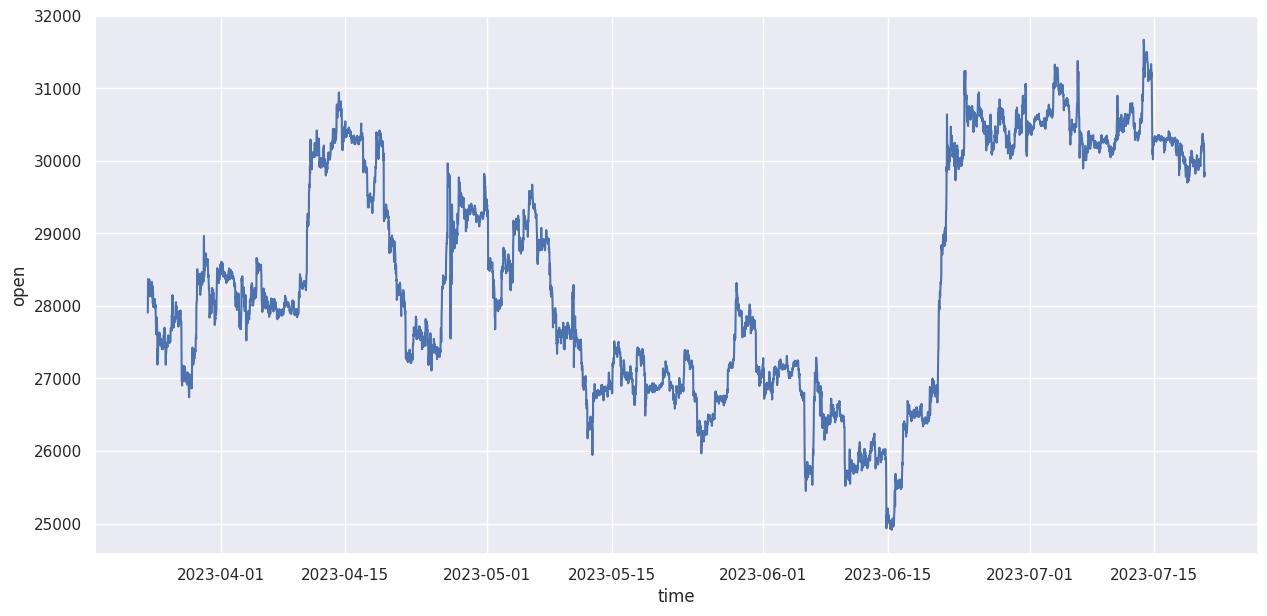

In [366]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=df,x='time',y='open')

# Correlation between trades and open price

<Axes: xlabel='open', ylabel='trades'>

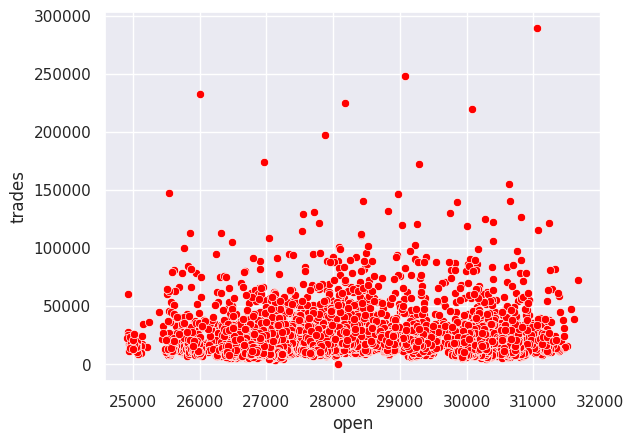

In [367]:
sns.scatterplot(data=df, x='open',y='trades',c='red')

# CREATING TIME TREND FEATURE

In [368]:
df['trend_2']=df.trend**2
df['trend_3']=df.trend**3
df['trend_4']=df.trend**4
X_time_trend=df[['trend','trend_2','trend_3','trend_4']]
y=df['open']

In [369]:
y_dummy = np.ones(len(y))*y.mean()

In [370]:
def check_model_full(model, X, y):
    model.fit(X, y)
    y_pred_1 = model.predict(X)
    print(f'r2 {r2_score(y,y_pred_1)}, absolute {mean_absolute_error(y,y_pred_1)}')
    sns.lineplot(data=df[len(df)-len(y):],x='time',y='open')
    sns.lineplot(x=df[len(df)-len(y):].time,y=y_pred_1,c='red')
    return y_pred_1

/home/kilka/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.810e+09, tolerance: 1.445e+06
  model = cd_fast.enet_coordinate_descent(


r2 0.47291492519879763, absolute 959.1492919921875


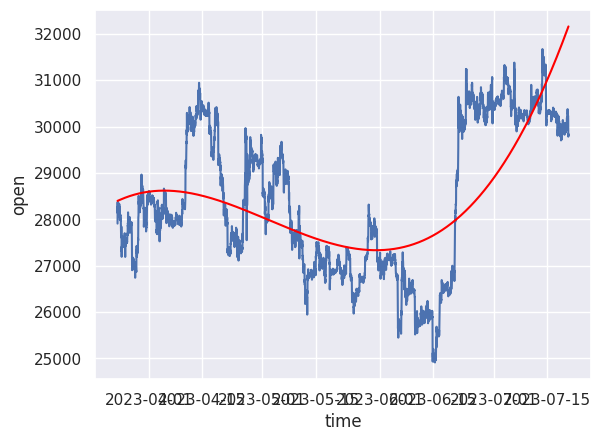

In [371]:
linear = check_model_full(Lasso(max_iter=1000), X_time_trend, y)

r2 0.9193672899158453, absolute 318.7477722167969


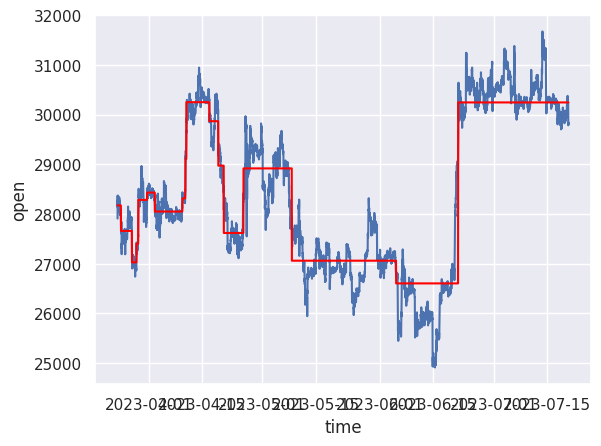

In [372]:
tree = check_model_full(XGBRegressor(n_estimators=2, max_depth=4, learning_rate=1), X_time_trend, y)

# CREATE MOVING AVERAGE

In [373]:
def plotMovingAverage(
    series, window, plot_intervals=False, scale=1.96, plot_anomalies=False
):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()
    rolling_variance = series.rolling(window=window).std()
    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    return rolling_mean, rolling_variance

# weekly average 

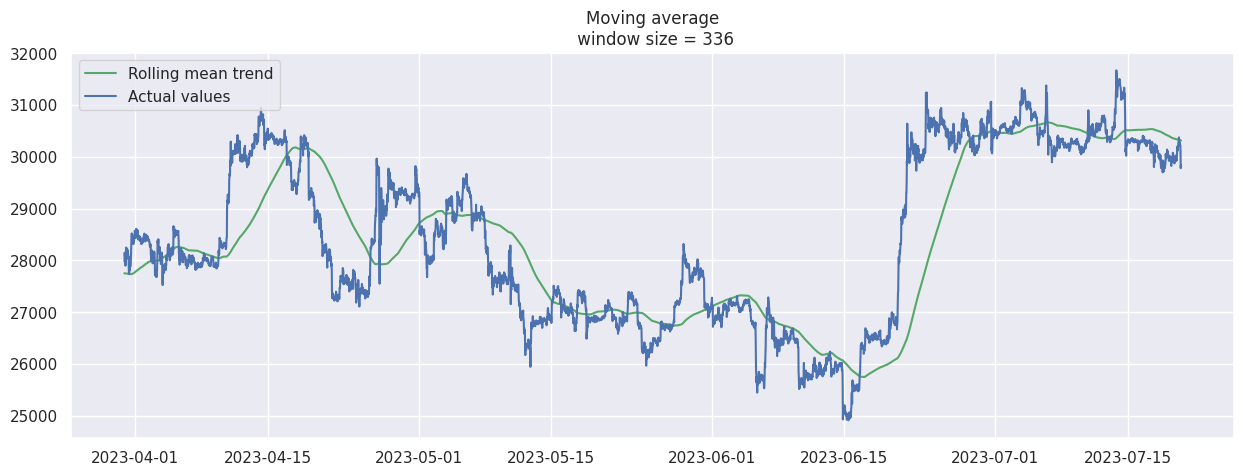

In [375]:
days=7
mov_av_w, mov_var_w = plotMovingAverage(y,int(48*days))

In [358]:
print(f'r2 {r2_score(y[int(288*days):],mov_av_w[int(288*days):])}, '
      f'absolute {mean_absolute_error(y[int(288*days):],mov_av_w[int(288*days):])}')

r2 -0.0519627163467542, absolute 1706.3850807378924


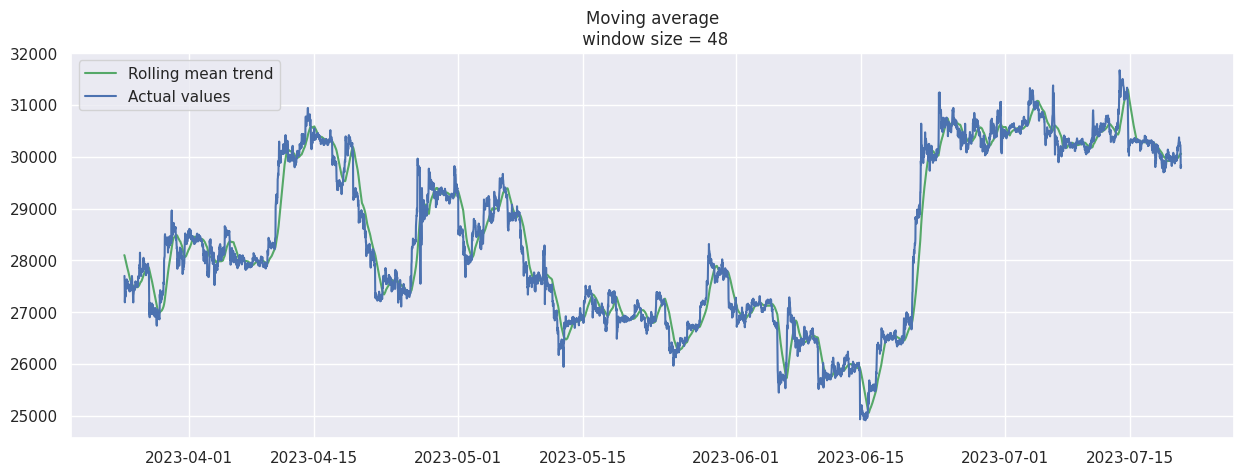

In [376]:
days=1
mov_av_d, mov_var_d = plotMovingAverage(y,int(48*days))

In [377]:
print(f'r2 {r2_score(y[int(288*days):],mov_av_d[int(288*days):])}, '
      f'absolute {mean_absolute_error(y[int(288*days):],mov_av_d[int(288*days):])}')

r2 0.9600370829000109, absolute 223.30454404033622


In [378]:
X=X_time_trend.copy()
X['trades'] = (df['trades'] - df['trades'].mean())/df.trades.std()
X['linear_trend'] = linear
X['tree_trend'] = tree
X['moving_average_weekly'] = mov_av_w
X['moving_average_daily'] = mov_av_d
X['moving_variance_weekly'] = mov_var_w
X['moving_variance_daily'] = mov_var_d
X['time'] = df.time

In [379]:
X.tail(5)

,trend,trend_2,trend_3,trend_4,trades,linear_trend,tree_trend,moving_average_weekly,moving_average_daily,moving_variance_weekly,moving_variance_daily,time
open_time,,,,,,,,,,,,
2023-07-20 14:00:00,5699.0,32478600.0,1.850956e+11,1.054860e+15,0.311355,32138.919922,30242.953125,30323.757882,30056.885864,444.039086,151.814932,2023-07-20 14:00:00
2023-07-20 14:30:00,5700.0,32490000.0,1.851930e+11,1.055600e+15,3.878751,32143.562500,30242.953125,30322.464071,30062.177531,443.997441,149.427792,2023-07-20 14:30:00
2023-07-20 15:00:00,5701.0,32501400.0,1.852905e+11,1.056341e+15,0.613073,32148.207031,30242.953125,30320.113473,30061.306681,444.762423,150.959356,2023-07-20 15:00:00
2023-07-20 15:30:00,5702.0,32512804.0,1.853880e+11,1.057082e+15,-0.150717,32152.851562,30242.953125,30317.211687,30060.556681,444.691499,151.975450,2023-07-20 15:30:00
2023-07-20 16:00:00,5703.0,32524208.0,1.854856e+11,1.057824e+15,-0.174751,32157.501953,30242.953125,30313.916120,30057.508952,444.332627,155.532648,2023-07-20 16:00:00


In [380]:
y

open_time
2023-03-23 19:30:00    27908.220703
2023-03-23 20:00:00    28369.820312
2023-03-23 20:30:00    28156.349609
2023-03-23 21:00:00    28280.029297
2023-03-23 21:30:00    28124.300781
                           ...     
2023-07-20 14:00:00    30229.570312
2023-07-20 14:30:00    30120.000000
2023-07-20 15:00:00    29782.199219
2023-07-20 15:30:00    29842.000000
2023-07-20 16:00:00    29810.169922
Name: open, Length: 5704, dtype: float32

# Seasonal features

In [381]:
def fourier_features(X, freq, order=4):
    X_copy = X.copy()
    time = X.trend
    k =  2 * np.pi * (1 / freq) * time
    for i in range(1, order+1):
        X_copy[f'sin_{i}'] = np.sin(i*k)
        X_copy[f'cos_{i}'] = np.cos(i*k)
    return X_copy

In [386]:
X_fourier = fourier_features(X_time_trend, 365.25*24).drop(['trend','trend_2','trend_3','trend_4'],axis=1)

<Axes: xlabel='open_time'>

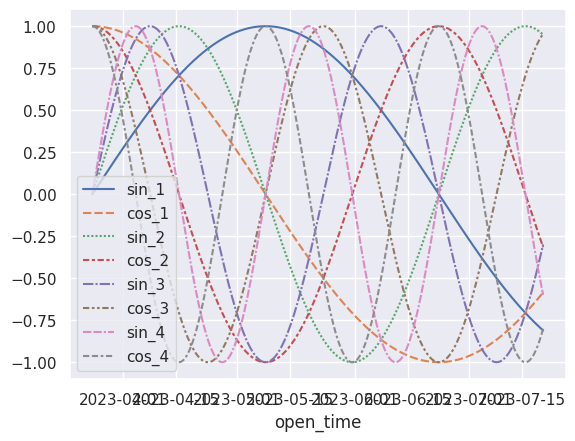

In [387]:
sns.lineplot(data=X_fourier)

In [388]:
X_fourier

,sin_1,cos_1,sin_2,cos_2,sin_3,cos_3,sin_4,cos_4
open_time,,,,,,,,
2023-03-23 19:30:00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2023-03-23 20:00:00,0.000717,1.000000,0.001434,0.999999,0.002150,0.999998,0.002867,0.999996
2023-03-23 20:30:00,0.001434,0.999999,0.002867,0.999996,0.004301,0.999991,0.005734,0.999984
2023-03-23 21:00:00,0.002150,0.999998,0.004301,0.999991,0.006451,0.999979,0.008601,0.999963
2023-03-23 21:30:00,0.002867,0.999996,0.005734,0.999984,0.008601,0.999963,0.011468,0.999934
...,...,...,...,...,...,...,...,...
2023-07-20 14:00:00,-0.809480,-0.587147,0.950568,-0.310516,-0.306767,0.951785,-0.590334,-0.807159
2023-07-20 14:30:00,-0.809901,-0.586567,0.950122,-0.311879,-0.304719,0.952442,-0.592645,-0.805464
2023-07-20 15:00:00,-0.810321,-0.585986,0.949674,-0.313241,-0.302669,0.953096,-0.594953,-0.803760


/home/kilka/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.230e+06, tolerance: 1.445e+06
  model = cd_fast.enet_coordinate_descent(


r2 0.7552068330238535, absolute 641.973388671875


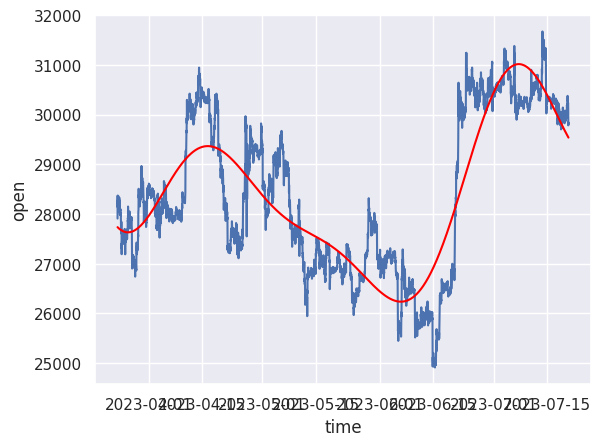

In [389]:
seasonal = check_model_full(Lasso(),X_fourier,y)

In [390]:
X['seasonal'] = seasonal

In [391]:
X.dtypes

trend                            float32
trend_2                          float32
trend_3                          float32
trend_4                          float32
trades                           float32
linear_trend                     float32
tree_trend                       float32
moving_average_weekly            float64
moving_average_daily             float64
moving_variance_weekly           float64
moving_variance_daily            float64
time                      datetime64[ns]
seasonal                         float32
dtype: object

# day of week, day of month, hour of day

In [392]:
dayofmonth = pd.Series(map(lambda x: x.date().day, X.time), index=X.index)
dayofweek = pd.Series(map(lambda x: x.date().weekday(), X.time), index=X.index)
hourofday = pd.Series(map(lambda x: x.time().hour, X.time), index=X.index)

In [393]:
X['day_of_month'] = dayofmonth
X['day_of_week'] = dayofweek
X['hour_of_day'] = hourofday

# Creating 1 day lags

In [394]:
def add_lags(X, interval='1h',count=24):
    X_copy = X.copy()
    if interval == '1h':
        for i in range(1,count+1):
            X_copy[f'lag_{i}h'] = y.shift(i)
    elif interval == '30m':
        for i in range(1,2*count+1):
            X_copy[f'lag_{i}'] = y.shift(i)
    return X_copy

In [395]:
X_lags = add_lags(X_time_trend).drop(['trend','trend_2','trend_3','trend_4'],axis=1)

r2 0.9969959221437042, absolute 53.06098175048828


array([28267.416, 28213.496, 28277.436, ..., 30112.91 , 29791.383,
       29849.64 ], dtype=float32)

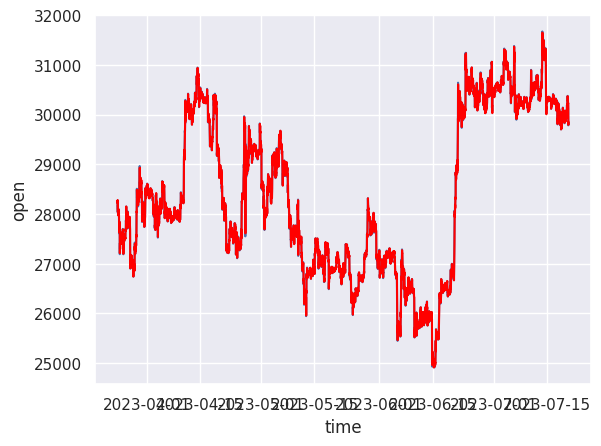

In [396]:
check_model_full(LinearRegression(),X_lags[24:],y[24:])

In [397]:
X=add_lags(X)

In [398]:
X.columns

Index(['trend', 'trend_2', 'trend_3', 'trend_4', 'trades', 'linear_trend',
       'tree_trend', 'moving_average_weekly', 'moving_average_daily',
       'moving_variance_weekly', 'moving_variance_daily', 'time', 'seasonal',
       'day_of_month', 'day_of_week', 'hour_of_day', 'lag_1h', 'lag_2h',
       'lag_3h', 'lag_4h', 'lag_5h', 'lag_6h', 'lag_7h', 'lag_8h', 'lag_9h',
       'lag_10h', 'lag_11h', 'lag_12h', 'lag_13h', 'lag_14h', 'lag_15h',
       'lag_16h', 'lag_17h', 'lag_18h', 'lag_19h', 'lag_20h', 'lag_21h',
       'lag_22h', 'lag_23h', 'lag_24h'],
      dtype='object')

In [399]:
X.tail()

,trend,trend_2,trend_3,trend_4,trades,linear_trend,tree_trend,moving_average_weekly,moving_average_daily,moving_variance_weekly,...,lag_15h,lag_16h,lag_17h,lag_18h,lag_19h,lag_20h,lag_21h,lag_22h,lag_23h,lag_24h
open_time,,,,,,,,,,,,,,,,,,,,,
2023-07-20 14:00:00,5699.0,32478600.0,1.850956e+11,1.054860e+15,0.311355,32138.919922,30242.953125,30323.757882,30056.885864,444.039086,...,30191.660156,30125.980469,30037.050781,29962.009766,29930.019531,29948.000000,29927.119141,29985.539062,30025.000000,29987.339844
2023-07-20 14:30:00,5700.0,32490000.0,1.851930e+11,1.055600e+15,3.878751,32143.562500,30242.953125,30322.464071,30062.177531,443.997441,...,30119.990234,30191.660156,30125.980469,30037.050781,29962.009766,29930.019531,29948.000000,29927.119141,29985.539062,30025.000000
2023-07-20 15:00:00,5701.0,32501400.0,1.852905e+11,1.056341e+15,0.613073,32148.207031,30242.953125,30320.113473,30061.306681,444.762423,...,30209.089844,30119.990234,30191.660156,30125.980469,30037.050781,29962.009766,29930.019531,29948.000000,29927.119141,29985.539062
2023-07-20 15:30:00,5702.0,32512804.0,1.853880e+11,1.057082e+15,-0.150717,32152.851562,30242.953125,30317.211687,30060.556681,444.691499,...,30202.779297,30209.089844,30119.990234,30191.660156,30125.980469,30037.050781,29962.009766,29930.019531,29948.000000,29927.119141
2023-07-20 16:00:00,5703.0,32524208.0,1.854856e+11,1.057824e+15,-0.174751,32157.501953,30242.953125,30313.916120,30057.508952,444.332627,...,30207.990234,30202.779297,30209.089844,30119.990234,30191.660156,30125.980469,30037.050781,29962.009766,29930.019531,29948.000000


# Cross-Validation and choosing final model

In [400]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """

    # get the index after which test set starts
    test_index = int(len(X) * (1 - test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [401]:
X['y'] = y
X = X.dropna().drop(['trend_4','time'],axis=1)
y = X['y']
X = X.drop('y',axis=1)

In [402]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.1)

In [403]:
def check_model_with_CV(model):
    print(f'CHECKING {model}')
    print()
    model.fit(X_train, y_train)

    print('Mean absolute error in train')
    print(mean_absolute_error(model.predict(X_train),y_train))
    print('Mean absolute error in test (1 percent of all data)')
    print(mean_absolute_error(model.predict(X_test),y_test))

    cv = cross_val_score(
                model, X_train, y_train, cv=tscv, scoring="neg_mean_absolute_error"
            )
    print()
    print('CROSS VALIDATION')
    for i in range(len(cv)):
        print(f'mean error in {i+1} split: '+ str(-cv[i]))
    return model

CHECKING LinearRegression()

Mean absolute error in train
53.196324917971786
Mean absolute error in test (1 percent of all data)
44.25383604094275

CROSS VALIDATION
mean error in 1 split: 14515.629818835065
mean error in 2 split: 831.4681949836937
mean error in 3 split: 162.4151699776093
mean error in 4 split: 78.99655994187793
mean error in 5 split: 69.5579510273737


<Axes: xlabel='open_time', ylabel='y'>

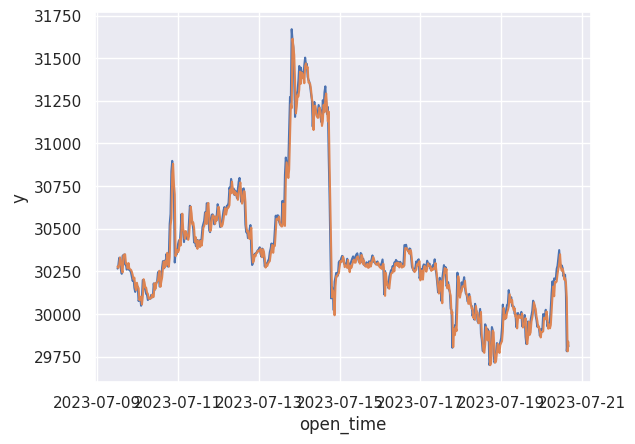

In [405]:
lr = check_model_with_CV(LinearRegression())

sns.lineplot(y_test)
sns.lineplot(pd.Series(lr.predict(X_test), index = y_test.index))

CHECKING RandomForestRegressor(max_depth=5, n_estimators=5)

Mean absolute error in train
59.6155359523638
Mean absolute error in test (1 percent of all data)
66.72292803790218

CROSS VALIDATION
mean error in 1 split: 776.9226103879474
mean error in 2 split: 384.56806418231577
mean error in 3 split: 121.68253063099496
mean error in 4 split: 319.4348135916631
mean error in 5 split: 133.47268162430663


<Axes: xlabel='open_time', ylabel='y'>

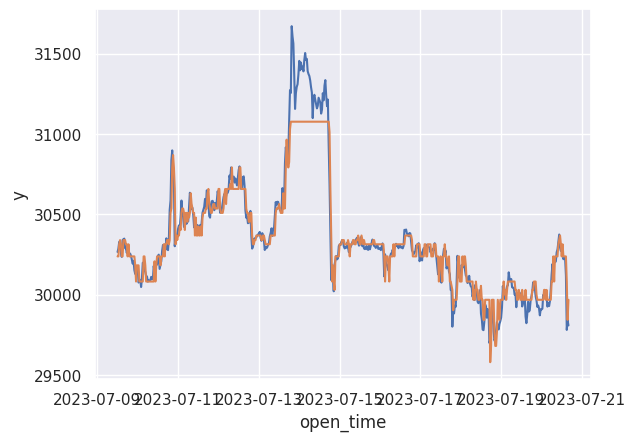

In [406]:
tree = check_model_with_CV(RandomForestRegressor(n_estimators=5, max_depth=5))

sns.lineplot(y_test)
sns.lineplot(pd.Series(tree.predict(X_test), index = y_test.index))

CHECKING Lasso(alpha=5, max_iter=5000)



/home/kilka/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.866e+07, tolerance: 1.193e+06
  model = cd_fast.enet_coordinate_descent(


Mean absolute error in train
53.06845086034797
Mean absolute error in test (1 percent of all data)
47.43464426557845


/home/kilka/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.110e+06, tolerance: 8.436e+04
  model = cd_fast.enet_coordinate_descent(
/home/kilka/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.472e+06, tolerance: 1.518e+05
  model = cd_fast.enet_coordinate_descent(
/home/kilka/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.07


CROSS VALIDATION
mean error in 1 split: 114.57688863671781
mean error in 2 split: 174.4536963908036
mean error in 3 split: 62.4072218960323
mean error in 4 split: 61.315199865092175
mean error in 5 split: 53.70669556319245


<Axes: xlabel='open_time', ylabel='y'>

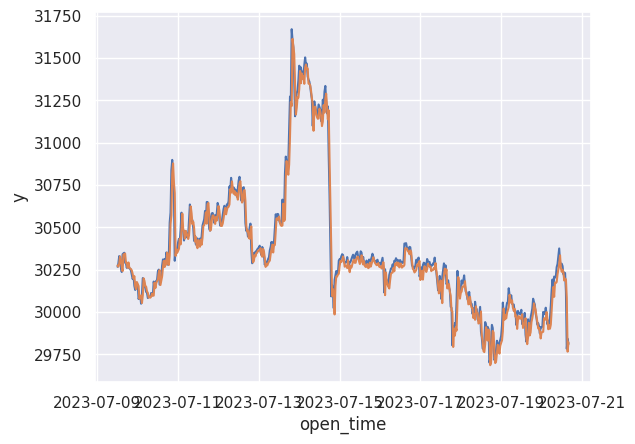

In [407]:
lasso = check_model_with_CV(Lasso(alpha=5,max_iter=5000))

sns.lineplot(y_test)
sns.lineplot(pd.Series(lasso.predict(X_test), index = y_test.index))

CHECKING Ridge(alpha=100, max_iter=5000)

Mean absolute error in train
53.19106868463328
Mean absolute error in test (1 percent of all data)
44.28602769451263

CROSS VALIDATION
mean error in 1 split: 13256.084526183966
mean error in 2 split: 209.26027269772166
mean error in 3 split: 107.72712123428717
mean error in 4 split: 73.03830046215008
mean error in 5 split: 68.98076283525064


/home/kilka/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.2832e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/kilka/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.29128e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/kilka/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.26962e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/kilka/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.62603e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/kilka/.local/lib/python3.10/site-packages/sklearn/l

<Axes: xlabel='open_time', ylabel='y'>

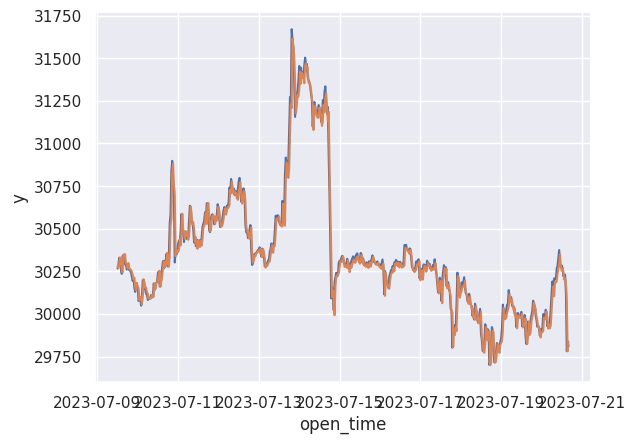

In [409]:
ridge = check_model_with_CV(Ridge(alpha=100,max_iter=5000))

sns.lineplot(y_test)
sns.lineplot(pd.Series(ridge.predict(X_test), index = y_test.index))

# Model evaluation for 1 month

In [410]:
def day_str(day):
    if day<=9:
        return '0'+str(day)
    return str(day)
def month_profit(model_fitted, month,start):
    total_profit = 0
    for day in range(1,30):
        sum_day = 0
        y_day = y[(y.index >= f"{month}-{day_str(day)} 00:00:00") & (y.index <= f"{month}-{day_str(day+1)} 00:00:00")]
        X_day = X[(X.index >= f"{month}-{day_str(day)} 00:00:00") & (X.index <= f"{month}-{day_str(day+1)} 00:00:00")]
        if len(y_day)>0:
            y_pred = model_fitted.predict(X_day)
        for i in range(1, len(y_day)):
            #if True:
            if y_pred[i]-y_day[i-1]>0:
                sum_day += ((start)*(y_day[i]/y_day[i-1]-1))
                start+=((start)*(y_day[i]/y_day[i-1]-1))
        print(f'Profit for day {day} is {sum_day}. Current money: {start}')
        total_profit += sum_day
    print()
    print()
    return start

In [415]:
month='2023-07'
print(f'Total profit for {month} is {month_profit(lasso,month,100)}')

Profit for day 1 is -0.22031797283965257. Current money: 99.77968202716036
Profit for day 2 is 0.41123594649509015. Current money: 100.19091797365544
Profit for day 3 is -0.04113739054366716. Current money: 100.14978058311176
Profit for day 4 is -0.04536141053742566. Current money: 100.10441917257434
Profit for day 5 is 0.4894522908977201. Current money: 100.59387146347207
Profit for day 6 is -0.5570170349206703. Current money: 100.0368544285514
Profit for day 7 is 0.7030938010470696. Current money: 100.73994822959847
Profit for day 8 is 0.22325696919278537. Current money: 100.96320519879126
Profit for day 9 is 0.17873474372045886. Current money: 101.14193994251171
Profit for day 10 is 0.8403657098059011. Current money: 101.98230565231763
Profit for day 11 is 0.0785926063375629. Current money: 102.0608982586552
Profit for day 12 is 0.20389402054628178. Current money: 102.26479227920149
Profit for day 13 is 0.32236431863771975. Current money: 102.58715659783921
Profit for day 14 is 0.25

# Model evaluation for 1 day

In [416]:
def eval_one_day(model,date, start):
    total_profit = 0
    y_day = y[(y.index>=f'{date} 00:00:00') & (y.index <=f'{date} 23:59:00')]
    X_day = X[(X.index>=f'{date} 00:00:00') & (X.index <=f'{date} 23:59:00')]
    y_pred = model.predict(X_day)
    sum_day=0
    for i in range(1,len(y_day)):
        if y_pred[i]-y_day[i-1]>0:
        #if True:
            sum_day += ((start)*(y_day[i]/y_day[i-1]-1))
            start += ((start)*(y_day[i]/y_day[i-1]-1))
            print(f'Profit: {((start)*(y_day[i]/y_day[i-1]-1))}, current money: {start}')
    return start

In [419]:
print(f'Total profit is {eval_one_day(lasso,"2023-06-11",100)}')

Profit: -0.2930644458270848, current money: 99.70607161521912
Profit: 0.1033715621402177, current money: 99.80933622720158
Profit: 0.18639896966489206, current money: 99.99538838157389
Profit: 0.007021596334769965, current money: 100.002409484927
Profit: -0.08443808471943243, current money: 99.91789998336981
Profit: -0.1602566869412805, current money: 99.75738543552399
Profit: 0.1616713778160511, current money: 99.91879564714866
Profit: 0.075789118408336, current money: 99.99452736601364
Profit: 0.27985640018863406, current money: 100.27360488098313
Profit: -0.10893359353230846, current money: 100.16455268813668
Profit: -0.017585334582627645, current money: 100.14696426510993
Profit: -0.01569063138473304, current money: 100.13127117460833
Profit: -0.1594745144130469, current money: 99.97154186013529
Profit: -0.022483332621529024, current money: 99.94905346879669
Profit: 0.01818537729165455, current money: 99.96723553852667
Profit: 0.09149907970391752, current money: 100.05865102293315


# Classification (ascending or not)

In [420]:
y, X.lag_1h

(open_time
 2023-03-30 20:00:00    27986.099609
 2023-03-30 20:30:00    27980.439453
 2023-03-30 21:00:00    28149.800781
 2023-03-30 21:30:00    28089.419922
 2023-03-30 22:00:00    28068.500000
                            ...     
 2023-07-20 14:00:00    30229.570312
 2023-07-20 14:30:00    30120.000000
 2023-07-20 15:00:00    29782.199219
 2023-07-20 15:30:00    29842.000000
 2023-07-20 16:00:00    29810.169922
 Name: y, Length: 5369, dtype: float32,
 open_time
 2023-03-30 20:00:00    28040.009766
 2023-03-30 20:30:00    27986.099609
 2023-03-30 21:00:00    27980.439453
 2023-03-30 21:30:00    28149.800781
 2023-03-30 22:00:00    28089.419922
                            ...     
 2023-07-20 14:00:00    30232.439453
 2023-07-20 14:30:00    30229.570312
 2023-07-20 15:00:00    30120.000000
 2023-07-20 15:30:00    29782.199219
 2023-07-20 16:00:00    29842.000000
 Name: lag_1h, Length: 5369, dtype: float32)

In [254]:
y_asc = y>X.lag_1h

In [289]:
best_model = lasso
y_asc_predict = best_model.predict(X) > X.lag_1h

In [291]:
accuracy_score(y_asc,y_asc_predict)#very poor quality of price prediction accuracy,so lets try to use classification

0.5306737295149809

In [292]:
y_asc_train = y_train>X_train.lag_1h
y_asc_test = y_test>X_test.lag_1h

In [300]:
class_model1 = LogisticRegression()

class_model1.fit(X_train, y_asc_train)
accuracy_score(y_asc_test,class_model1.predict(X_test))
accuracy_score(y_asc_train,class_model1.predict(X_train))

0.5020968216597999

In [308]:
class_model2 = RandomForestClassifier(max_depth=5)

class_model2.fit(X_train, y_asc_train)
print(precision_score(y_asc_test,class_model2.predict(X_test)))
print(precision_score(y_asc_train,class_model2.predict(X_train)))

0.4850444624090542
0.6026936026936027


In [309]:
class_model3 = MLPClassifier()

class_model3.fit(X_train, y_asc_train)
print(precision_score(y_asc_test,class_model3.predict(X_test)))
print(precision_score(y_asc_train,class_model3.predict(X_train)))

0.4968553459119497
0.4979031783402001


In [ ]:
def classification_eval()